# Vanilla RNN, Country-Wide Daily Cases Data for Germany

Trying out the Vanilla RNN model on the country-wide data for Germany

## Task and RNN Model

**Data**: Time-series for Germany from European Regional Tracker Dataset
- Time series $\mathbf{y} = [\mathbf{y}(1), \mathbf{y}(2), ..., \mathbf{y}(T)]^t$
- $\mathbf{y}(t) \in \mathbb{R}$ denotes  (normalized) number of new cases on $t$-th recorded day

**Model**: *Autonomous* Vanilla RNN
- Equations: 
$$
\mathbf{h}(t+1) = \tanh \big( \mathbf{W}_{hh} \mathbf{h}(t) + \mathbf{b}_h\big)
$$
$$
\mathbf{y}_{pred}(t) = \tanh\big(\mathbf{W}_{hy} \mathbf{h}(t) + b_y \big)
$$
- Trainable parameters:
    - Hidden-hidden weights $\mathbf{W}_{hh}$, a $N_h \times N_h$ matrix
    - Hidden-output weights $\mathbf{W}_{hy}$, a $1 \times N_h$ matrix
    - Hidden bias vector $\mathbf{b}_{h}$, a $N_h$-D Vector
    - Output bias vector $b_{y}$, a scalar
    - Initial Hidden State $\mathbf{h}(0)$, a $N_h$-D Vector
    
**Optimization Goal**: Train RNN such that $\mathbf{y}_{pred}$ close to $\mathbf{y}$

More specifically, we want to find $\mathbf{\Theta} = (\mathbf{W}_{hh}, \mathbf{W}_{hy}, \mathbf{b}_{h}, b_y \mathbf{h}(0))$ that minimizes

$$
\textrm{RMSE}(\mathbf{y}, \mathbf{y}_{pred}) = \bigg[\frac{1}{T} \sum_{t=1}^T |\mathbf{y}(t) - \mathbf{y}_{pred}(t)|^2\bigg]^{1/2} 
$$


In [1]:
# Change root directory
import sys, os
sys.path.append(os.path.abspath('../../'))

In [2]:
# Package Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits import mplot3d
from sklearn.decomposition import PCA

# MLP text size
import matplotlib
matplotlib.rc('font', size=16)

In [3]:
# Local Imports
from src.baseline_models import RNN
from src.load_data import ERT_germany
from src.train_and_eval import train
from src.clustering import hierarchical_clustering

## Parameters

In [4]:
# Dataset parameters
dtype = 'cases_daily'
T = 100
country_wide_total = True

# Model parameters
N_h = 64
p_hh = 1
g_hh = 1.
f_h = 'tanh'
f_out = 'tanh'
sigma = 0e-3 # noise parameter
tau = 1
learn_tau = False

# Training parameters
n_epochs = 3 * 256
lr = 5e-4
lr_decay = 0.75
weight_decay = 0.0
batches_til_first_lr_update=256
clip_gradient_thres=None
verbose = True

## Setup

In [5]:
# Random Seed
seed = 349217 # np.random.randint(1e6) # 349217
print('Random seed: %d' % seed)
np.random.seed(seed)

# Load the dataset
# directory where the data is stored, relative to this script
datadir = '../../euro_regional_tracker/germany_data/data'
# load the data from file
y_raw = ERT_germany(dtype=dtype, seq_len=T, country_wide_total=country_wide_total,
    normalize=False, datadir=datadir
)
# Save the sequence length
T = y_raw.shape[0]
# Create the input sequence (all zeros for now)
u = torch.zeros(1, T, 0)
# Reshape y_raw and save as the target y
y = y_raw.clone().view(1, T, 1)
y = y.view(1, T, 1)
# Normalize to -1,1
y -= y.min()
y /= 0.5 * y.max()
y -= 1

# Create the RNN model
network = RNN(
    0, N_h, 1, # Only one output for now
    f_h=f_h, f_out=f_out, g_hh=g_hh, p_hh=p_hh,
    tau=tau, learn_tau=learn_tau
)

Random seed: 349217


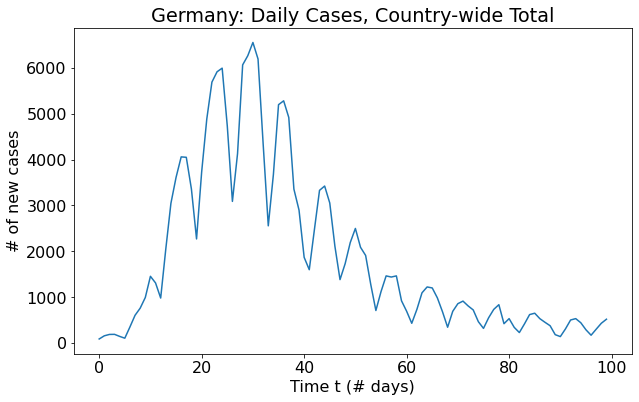

In [6]:
# Plot of what the raw data looks like
plt.figure(figsize=(10,6))
plt.title('Germany: Daily Cases, Country-wide Total')
plt.xlabel('Time t (# days)')
plt.ylabel('# of new cases')
plt.plot(y_raw)
plt.show()

## Training

In [7]:
losses, = train(network, u, y, n_epochs, 1, lr, lr_decay=lr_decay,
        weight_decay=weight_decay,
        batches_til_first_lr_update=batches_til_first_lr_update,
        clip_gradient_thres=clip_gradient_thres, verbose=True
)

  Epoch 1/768, Eval 1/1, Loss: 1.012
  Epoch 2/768, Eval 1/1, Loss: 1.260
  Epoch 3/768, Eval 1/1, Loss: 1.066
  Epoch 4/768, Eval 1/1, Loss: 0.431
  Epoch 5/768, Eval 1/1, Loss: 0.507
  Epoch 6/768, Eval 1/1, Loss: 0.504
  Epoch 7/768, Eval 1/1, Loss: 0.472
  Epoch 8/768, Eval 1/1, Loss: 0.435
  Epoch 9/768, Eval 1/1, Loss: 0.400
  Epoch 10/768, Eval 1/1, Loss: 0.362
  Epoch 11/768, Eval 1/1, Loss: 0.317
  Epoch 12/768, Eval 1/1, Loss: 0.417
  Epoch 13/768, Eval 1/1, Loss: 0.322
  Epoch 14/768, Eval 1/1, Loss: 0.358
  Epoch 15/768, Eval 1/1, Loss: 0.375
  Epoch 16/768, Eval 1/1, Loss: 0.384
  Epoch 17/768, Eval 1/1, Loss: 0.388
  Epoch 18/768, Eval 1/1, Loss: 0.390
  Epoch 19/768, Eval 1/1, Loss: 0.390
  Epoch 20/768, Eval 1/1, Loss: 0.389
  Epoch 21/768, Eval 1/1, Loss: 0.388
  Epoch 22/768, Eval 1/1, Loss: 0.385
  Epoch 23/768, Eval 1/1, Loss: 0.382
  Epoch 24/768, Eval 1/1, Loss: 0.378
  Epoch 25/768, Eval 1/1, Loss: 0.374
  Epoch 26/768, Eval 1/1, Loss: 0.369
  Epoch 27/768, Eval 

  Epoch 216/768, Eval 1/1, Loss: 0.043
  Epoch 217/768, Eval 1/1, Loss: 0.042
  Epoch 218/768, Eval 1/1, Loss: 0.042
  Epoch 219/768, Eval 1/1, Loss: 0.042
  Epoch 220/768, Eval 1/1, Loss: 0.042
  Epoch 221/768, Eval 1/1, Loss: 0.042
  Epoch 222/768, Eval 1/1, Loss: 0.042
  Epoch 223/768, Eval 1/1, Loss: 0.042
  Epoch 224/768, Eval 1/1, Loss: 0.042
  Epoch 225/768, Eval 1/1, Loss: 0.042
  Epoch 226/768, Eval 1/1, Loss: 0.042
  Epoch 227/768, Eval 1/1, Loss: 0.042
  Epoch 228/768, Eval 1/1, Loss: 0.041
  Epoch 229/768, Eval 1/1, Loss: 0.041
  Epoch 230/768, Eval 1/1, Loss: 0.041
  Epoch 231/768, Eval 1/1, Loss: 0.041
  Epoch 232/768, Eval 1/1, Loss: 0.041
  Epoch 233/768, Eval 1/1, Loss: 0.041
  Epoch 234/768, Eval 1/1, Loss: 0.041
  Epoch 235/768, Eval 1/1, Loss: 0.041
  Epoch 236/768, Eval 1/1, Loss: 0.041
  Epoch 237/768, Eval 1/1, Loss: 0.041
  Epoch 238/768, Eval 1/1, Loss: 0.041
  Epoch 239/768, Eval 1/1, Loss: 0.041
  Epoch 240/768, Eval 1/1, Loss: 0.041
  Epoch 241/768, Eval 1/1

  Epoch 427/768, Eval 1/1, Loss: 0.014
  Epoch 428/768, Eval 1/1, Loss: 0.014
  Epoch 429/768, Eval 1/1, Loss: 0.014
  Epoch 430/768, Eval 1/1, Loss: 0.014
  Epoch 431/768, Eval 1/1, Loss: 0.014
  Epoch 432/768, Eval 1/1, Loss: 0.014
  Epoch 433/768, Eval 1/1, Loss: 0.014
  Epoch 434/768, Eval 1/1, Loss: 0.014
  Epoch 435/768, Eval 1/1, Loss: 0.014
  Epoch 436/768, Eval 1/1, Loss: 0.014
  Epoch 437/768, Eval 1/1, Loss: 0.014
  Epoch 438/768, Eval 1/1, Loss: 0.013
  Epoch 439/768, Eval 1/1, Loss: 0.013
  Epoch 440/768, Eval 1/1, Loss: 0.013
  Epoch 441/768, Eval 1/1, Loss: 0.013
  Epoch 442/768, Eval 1/1, Loss: 0.013
  Epoch 443/768, Eval 1/1, Loss: 0.013
  Epoch 444/768, Eval 1/1, Loss: 0.013
  Epoch 445/768, Eval 1/1, Loss: 0.013
  Epoch 446/768, Eval 1/1, Loss: 0.013
  Epoch 447/768, Eval 1/1, Loss: 0.013
  Epoch 448/768, Eval 1/1, Loss: 0.013
  Epoch 449/768, Eval 1/1, Loss: 0.013
  Epoch 450/768, Eval 1/1, Loss: 0.013
  Epoch 451/768, Eval 1/1, Loss: 0.013
  Epoch 452/768, Eval 1/1

  Epoch 639/768, Eval 1/1, Loss: 0.010
  Epoch 640/768, Eval 1/1, Loss: 0.010
  Epoch 641/768, Eval 1/1, Loss: 0.010
  Epoch 642/768, Eval 1/1, Loss: 0.010
  Epoch 643/768, Eval 1/1, Loss: 0.010
  Epoch 644/768, Eval 1/1, Loss: 0.010
  Epoch 645/768, Eval 1/1, Loss: 0.010
  Epoch 646/768, Eval 1/1, Loss: 0.010
  Epoch 647/768, Eval 1/1, Loss: 0.010
  Epoch 648/768, Eval 1/1, Loss: 0.010
  Epoch 649/768, Eval 1/1, Loss: 0.010
  Epoch 650/768, Eval 1/1, Loss: 0.010
  Epoch 651/768, Eval 1/1, Loss: 0.010
  Epoch 652/768, Eval 1/1, Loss: 0.010
  Epoch 653/768, Eval 1/1, Loss: 0.010
  Epoch 654/768, Eval 1/1, Loss: 0.010
  Epoch 655/768, Eval 1/1, Loss: 0.010
  Epoch 656/768, Eval 1/1, Loss: 0.010
  Epoch 657/768, Eval 1/1, Loss: 0.010
  Epoch 658/768, Eval 1/1, Loss: 0.010
  Epoch 659/768, Eval 1/1, Loss: 0.010
  Epoch 660/768, Eval 1/1, Loss: 0.010
  Epoch 661/768, Eval 1/1, Loss: 0.010
  Epoch 662/768, Eval 1/1, Loss: 0.010
  Epoch 663/768, Eval 1/1, Loss: 0.010
  Epoch 664/768, Eval 1/1

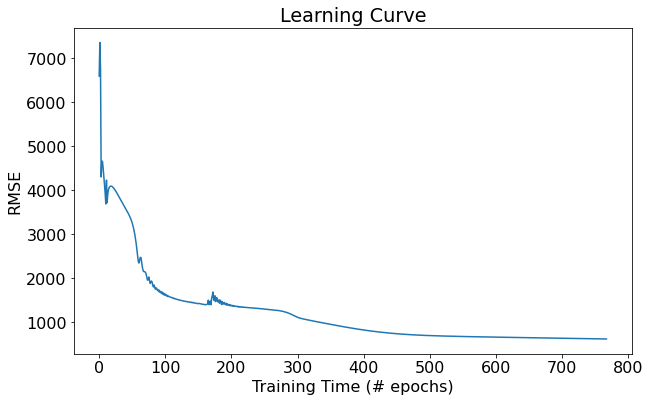

In [8]:
# Rescale losses to be in # of cases
rescaled_RMSE = y_raw.max() * np.sqrt(losses)

# Plot the learning curve
plt.figure(figsize=(10,6))
plt.title('Learning Curve')
plt.xlabel('Training Time (# epochs)')
plt.ylabel(r'RMSE')
plt.plot(rescaled_RMSE)
plt.show()

## Visualization

In [26]:
# Visualize predictions until user tells us otherwise
T_viz = int(1.5 * T)

# Make a prediction
with torch.no_grad():
    hd, y_pred = network(torch.zeros(1,T_viz,0), return_dynamics=True)

# Reshape and normalize
H = hd.detach().numpy().reshape(-1, N_h)
# H = (H - np.mean(H, axis=0)) # / np.std(H, axis=0)

# Target task for T=T_viz
y_viz = ERT_germany(dtype=dtype, seq_len=T_viz, country_wide_total=country_wide_total,
    normalize=False, datadir=datadir
)
# Reshape y_viz and y_pred
y_viz = y_viz.view(T_viz)
y_pred = y_pred.view(T_viz)

# Re-scale y_pred to be in units of # of cases
y_pred = (1 + y_pred) * y_raw.max() * 0.5

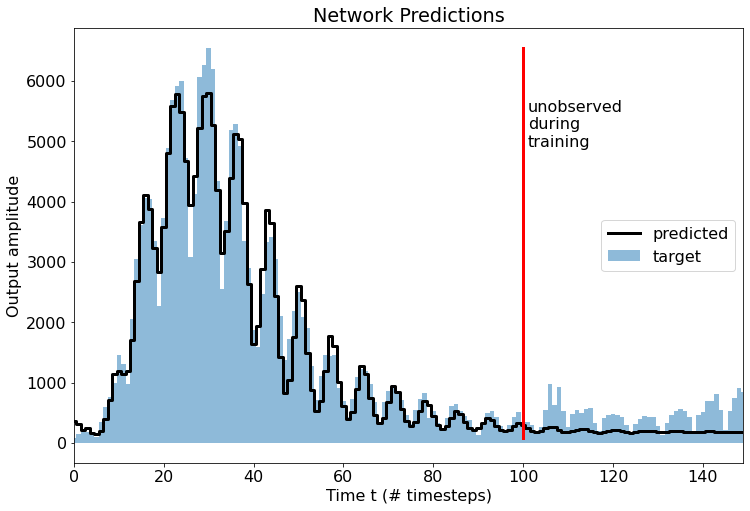

In [27]:
"""
Visualize predictions
"""
plt.figure(figsize=(12,8))
plt.title('Network Predictions')
plt.xlabel('Time t (# timesteps)')
plt.ylabel('Output amplitude')
plt.xlim(0,T_viz-1)
# Plot output target
plt.fill_between(
    np.arange(T_viz), y_viz,
    step='mid', alpha=0.5,
    label='target'
)
# Plot network prediction
plt.plot(
    np.arange(T_viz), y_pred,
    ds='steps-mid', c='k', linewidth=3,
    label='predicted'
)
plt.legend(loc='center right')
# Add a line to indicate data the network saw during training
plt.plot([T,T],[y_viz.min(), y_viz.max()], 'r', linewidth=3)
plt.text(T + 1, y_viz.max() * 0.75, 'unobserved\nduring\ntraining')
plt.show()

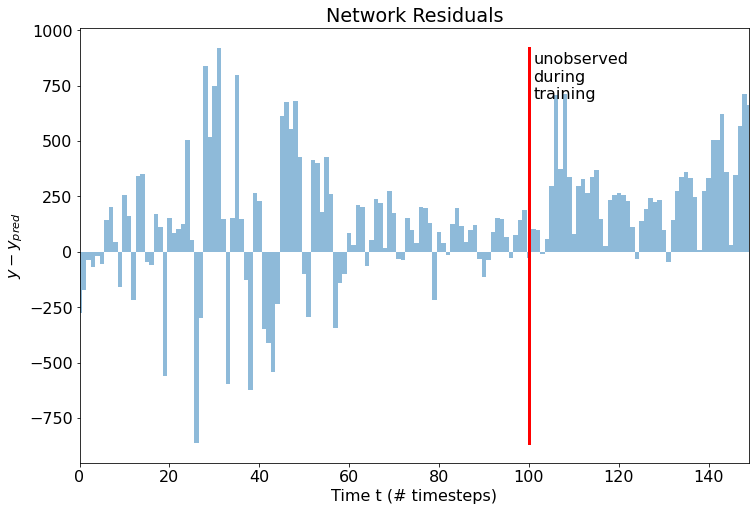

In [11]:
"""
Visualize residuals
"""
residuals = y_viz-y_pred

plt.figure(figsize=(12,8))
plt.title('Network Residuals')
plt.xlabel('Time t (# timesteps)')
plt.ylabel(r'$y - y_{pred}$')
plt.xlim(0,T_viz-1)
# Plot output target
plt.fill_between(
    np.arange(T_viz), y_viz-y_pred,
    step='mid', alpha=0.5,
)
# Add a line to indicate data the network saw during training
plt.plot([T,T],[residuals.min(), residuals.max()], 'r', linewidth=3)
plt.text(T + 1, residuals.max() * 0.75, 'unobserved\nduring\ntraining')
plt.show()

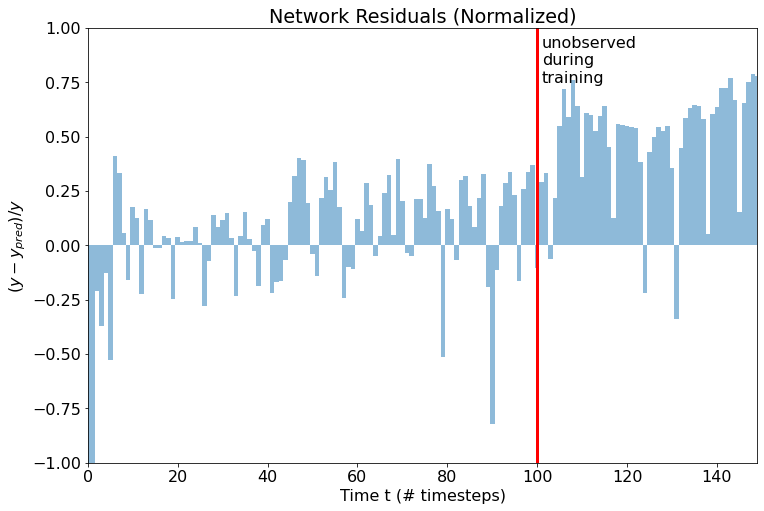

In [16]:
"""
Visualize residuals v2
"""
normalized_residuals = (y_viz-y_pred)/y_viz

plt.figure(figsize=(12,8))
plt.title('Network Residuals (Normalized)')
plt.xlabel('Time t (# timesteps)')
plt.ylabel(r'$(y - y_{pred}) / y$')
plt.xlim(0,T_viz-1)
plt.ylim(-1,1)
# Plot output target
plt.fill_between(
    np.arange(T_viz), normalized_residuals,
    step='mid', alpha=0.5,
)
# Add a line to indicate data the network saw during training
plt.plot([T,T],[-1,1], 'r', linewidth=3)
plt.text(T + 1, 0.75, 'unobserved\nduring\ntraining')
plt.show()

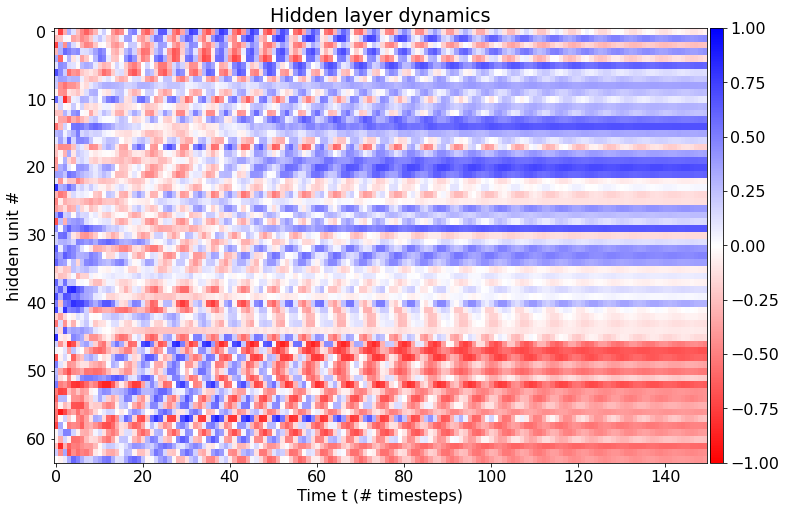

In [15]:
"""
Dynamics heatmap
"""

# Reshape and normalize
H = hd.detach().numpy().reshape(-1, N_h)
H_centered = (H - np.mean(H, axis=0)) # / np.std(H, axis=0)

# Clustering
order = hierarchical_clustering(H_centered)

# Reorder dynamics heatmap
h_viz = np.zeros_like(H.T)
# Reorder columns of h
for j in range(N_h):
    h_viz[j] = H[:,order[j]]

plt.figure(figsize=(12,8))
plt.title('Hidden layer dynamics')
plt.xlabel('Time t (# timesteps)')
plt.ylabel('hidden unit #')
vmxx = np.max(np.abs(h_viz))
im = plt.imshow(h_viz, aspect='auto', interpolation='none', cmap='bwr_r',
    vmin=-1,vmax=1
)
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="2%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

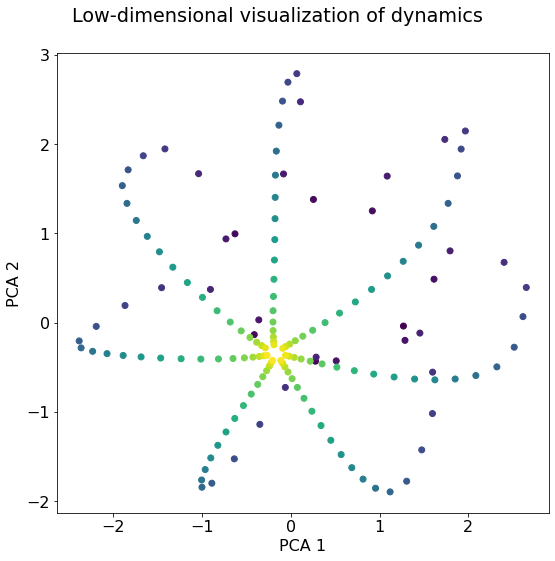

In [14]:
"""
PCA of Dynamics
"""

fig, ax = plt.subplots(1,1,figsize=(8,8))
fig.suptitle('Low-dimensional visualization of dynamics')

# Subplot 1: PCA
pca = PCA(n_components=5)
H_pca = pca.fit_transform(h_viz.T)

# ax0 = fig.add_subplot(111, projection='3d')
# ax0.set_title('PCA of network dynamics')
# ax0.set_xlabel('PCA 0')
# ax0.set_ylabel('PCA 1')
# ax0.set_zlabel('PCA 2')
# PCA_inds = [0,1,2]
# ax0.scatter(
#     H_pca[:, PCA_inds[0]],
#     H_pca[:, PCA_inds[1]],
#     H_pca[:, PCA_inds[2]],
#     c=np.arange(T_viz)/T_viz
# )

PCA_inds = [1,2]
ax.set_xlabel('PCA %d' % PCA_inds[0])
ax.set_ylabel('PCA %d' % PCA_inds[1])
ax.scatter(
    H_pca[:, PCA_inds[0]],
    H_pca[:, PCA_inds[1]],
    c=np.arange(T_viz)/T_viz
)

plt.tight_layout()
plt.show()

## Potential Ideas

- Transfer learning (idea from Carl)
  - Train on data from the flu
  - See if this known is sufficient to see how covid evolves
- Train up to first half of second wave, so how well RNN does testing on second half of second wave 
- Use smaller RNN to see how few params we need to get good output
- Also, actually get the RNN input